In [1]:
import os
from tensorflow import keras
from methods.config import *
from methods.clean_data import Data_Prep
from methods.nn import get_NN_results
from methods.var import get_VAR_results
from methods.model_results import get_model_details, get_best_model_name
from methods.data_methods import prepare_model_data
from methods.plot import plot_variables, plot_results
from methods.residual_bootstrap import get_prediction_intervals


C:\Users\zhufe\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zhufe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\zhufe\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Select Model

In [2]:
end_year = 2017
variable = 'UNRATE'
output_steps = 1

# Vector Auto-Regression

In [3]:
data_prep = Data_Prep(DATA_PATH, TRANSFORM_PATH)
data_prep.transform_to_supervised_learning(NA_CUTOFF, TARGET_VARIABLES, output_steps = output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
var_dataset = data_prep.supervised_dataset
Var_results = get_VAR_results(var_dataset, test_steps = TEST_STEPS, val_steps = VAL_STEPS, output_steps = output_steps)

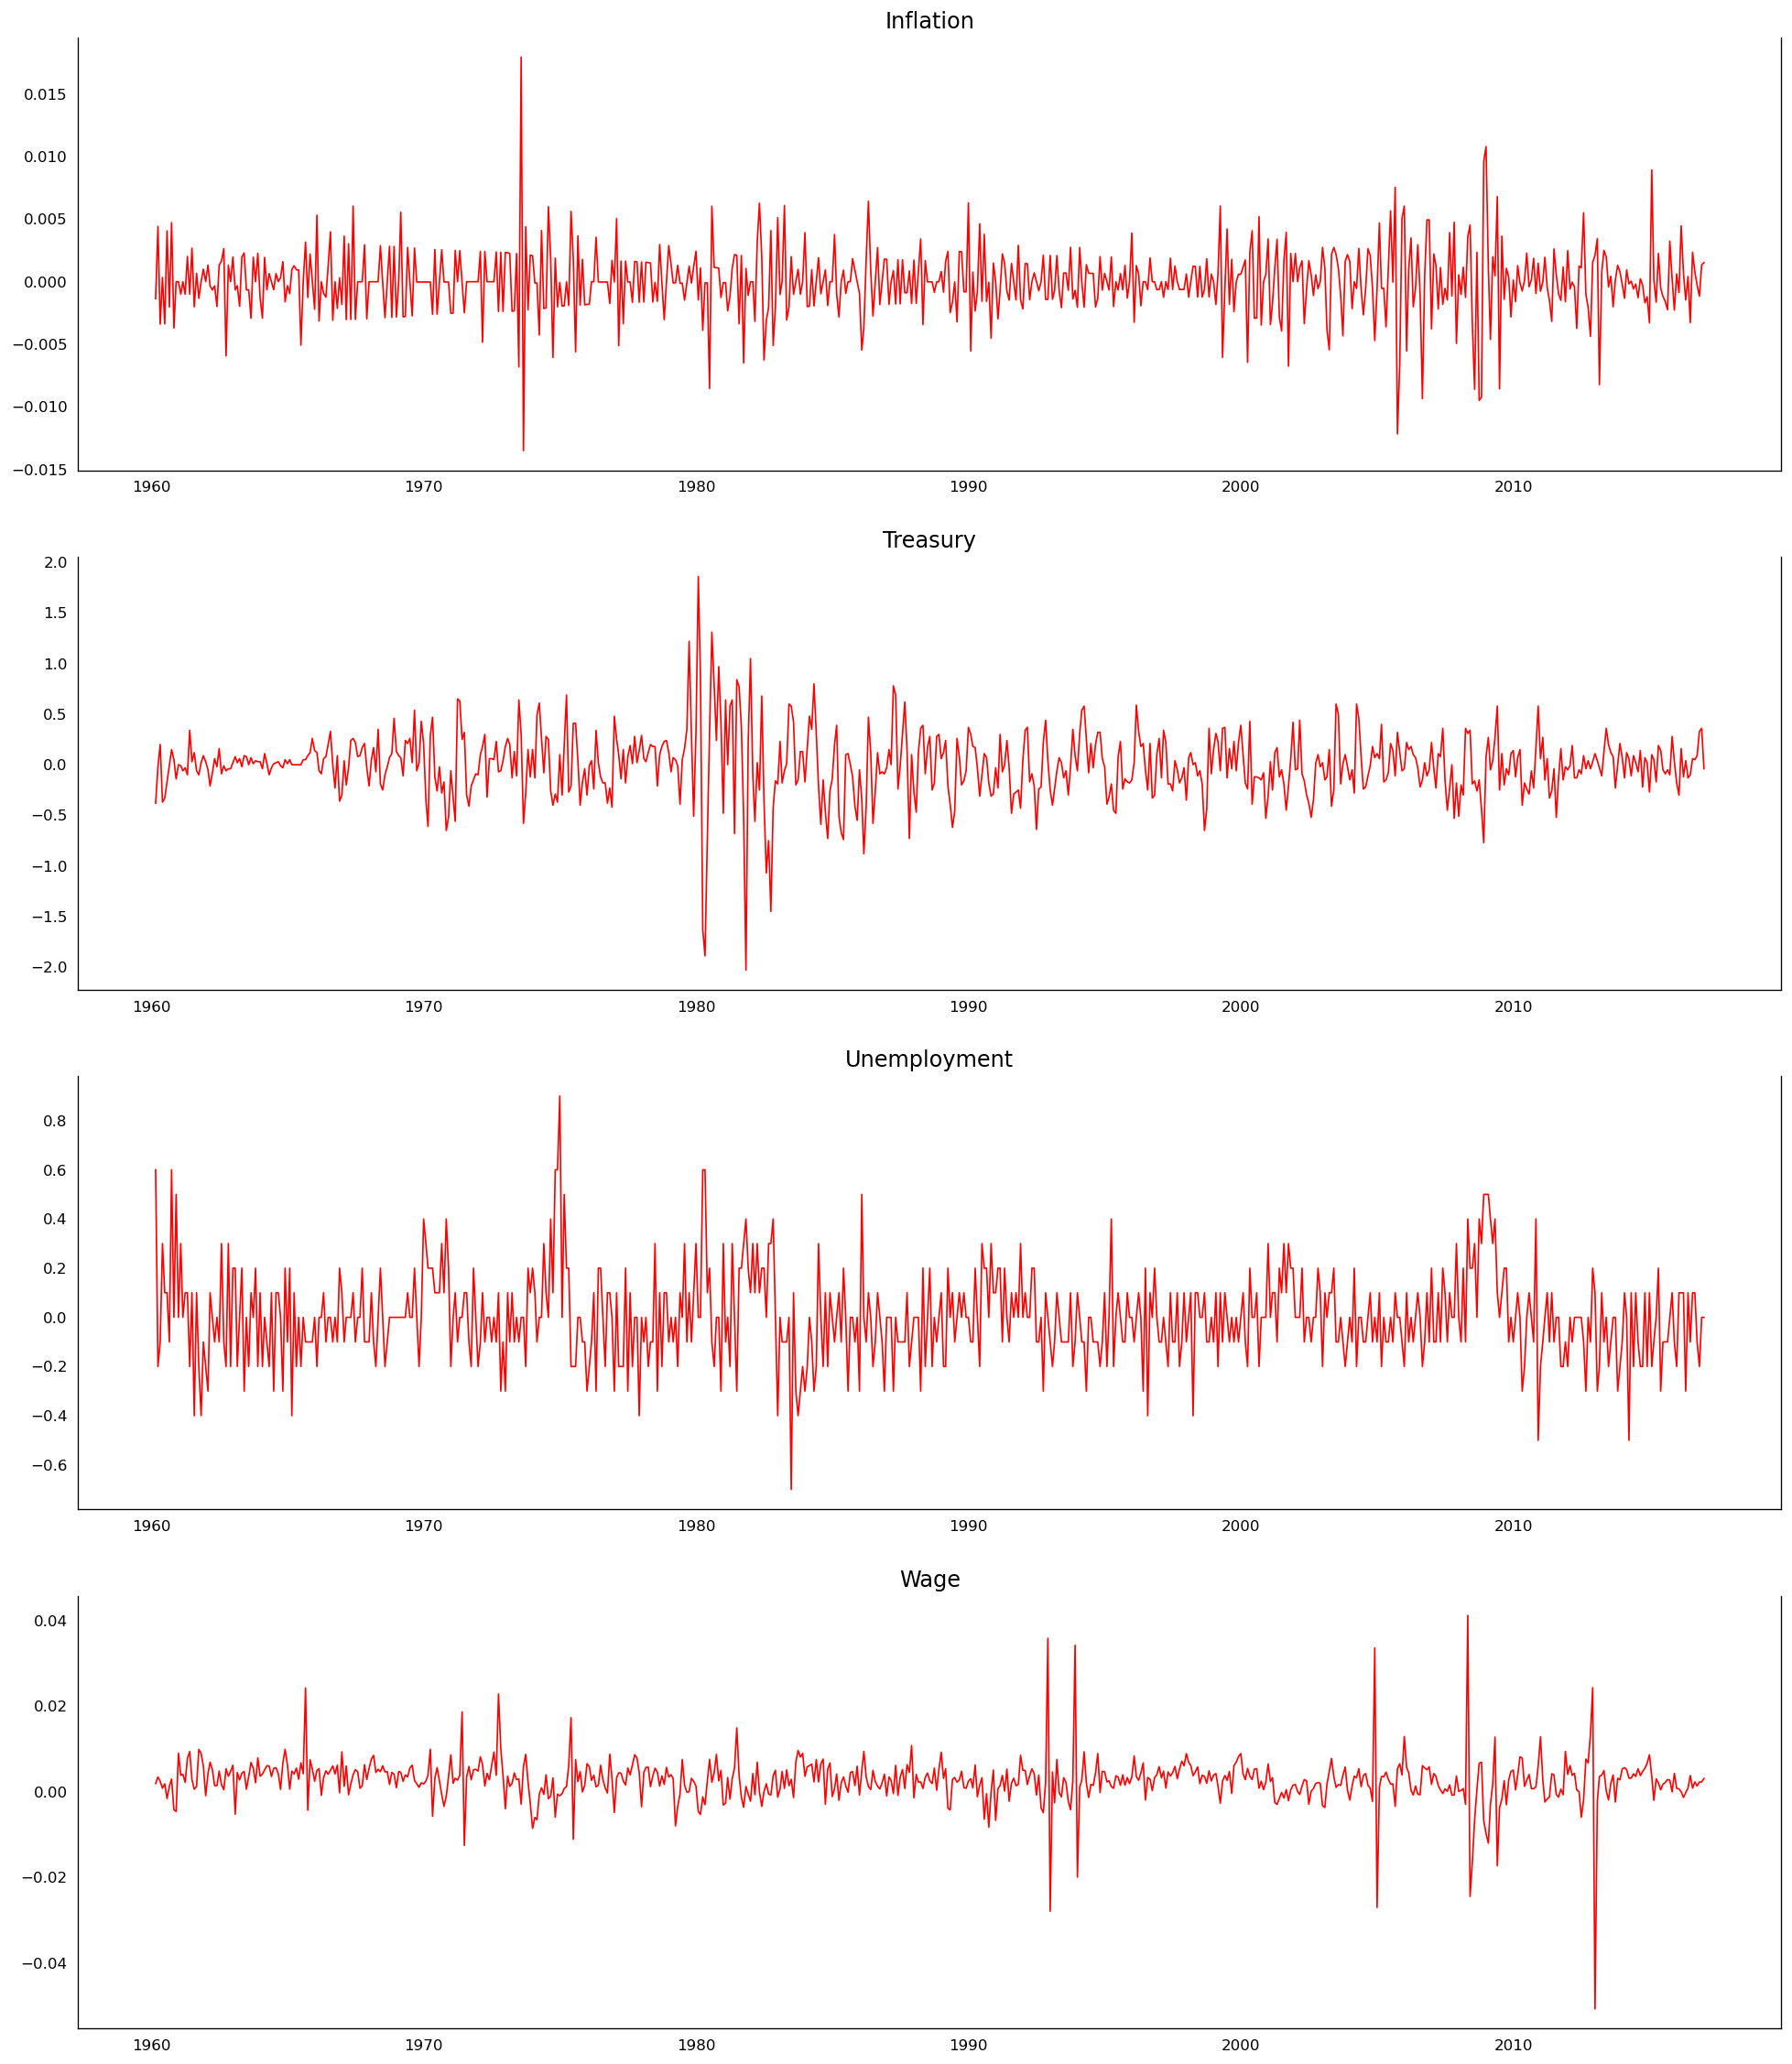

In [4]:
plot_variables(var_dataset)

# Neural Network

In [5]:
model_name = get_best_model_name(end_year, variable, output_steps)
model = keras.models.load_model(os.path.join(MODELS_PATH,model_name))

In [6]:
model_details = get_model_details(end_year, variable, output_steps)
look_back_steps = int(model_details['look_back_years']*12)
number_of_pca = model_details['number_of_pca']

In [7]:
model_details['model_parameters']

{'learning_rate': 0.001,
 'CNN_layers': 2,
 'LSTM_layers': 0,
 'Dense_layers': 1,
 'Dropout_prob': 0.2,
 'CNN_0_filters': 64,
 'LSTM_0_units': 128,
 'Dense_0_units': 128,
 'LSTM_1_units': 96,
 'Dense_1_units': 64,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0,
 'CNN_1_filters': 32}

In [8]:
data_prep.transform_to_supervised_learning(NA_CUTOFF, [variable], output_steps, start = f'{START_YEAR}-01-01', end = f'{end_year}-01-01')
dataset = data_prep.supervised_dataset
full_dataset = dataset['transformed_data']

In [9]:
data = prepare_model_data(window = full_dataset, X_variables = dataset['X_variables'], 
                Y_variables = dataset['Y_variables'], val_steps = VAL_STEPS, look_back = look_back_steps,
                test_steps = TEST_STEPS, remove_outlier = REMOVE_OUTLIER, number_of_pca = number_of_pca,
                target_variables = dataset['target_variables'])

data['train_X'] = data['train_X'][len(data['train_X'])%BATCH_SIZE:]
data['train_Y'] = data['train_Y'][len(data['train_Y'])%BATCH_SIZE:]

In [10]:
NN_results = get_NN_results(model, data, VAL_STEPS, TEST_STEPS, look_back_steps, dataset,  BATCH_SIZE, EPOCHS, executions = 5)

Fitting: 1
Fitting: 2
Fitting: 3
Fitting: 4
Fitting: 5


# Compare Results

In [11]:
val_result = {k:v/Var_results['val']['error'][k] for k,v in NN_results['val']['error'].items()}
val_result['average'] = sum(val_result.values())/len(val_result.values())
val_result_raw = {k:v/Var_results['val']['error_raw'][k] for k,v in NN_results['val']['error_raw'].items()}
val_result

{'UNRATE': 0.5048911685607217, 'average': 0.5048911685607217}

In [12]:
test_result = {k:v/Var_results['test']['error'][k] for k,v in NN_results['test']['error'].items()}
test_result['average'] = sum(test_result.values())/len(test_result.values())
test_result_raw = {k:v/Var_results['test']['error_raw'][k] for k,v in NN_results['test']['error_raw'].items()}
test_result

{'UNRATE': 0.9253609689375751, 'average': 0.9253609689375751}

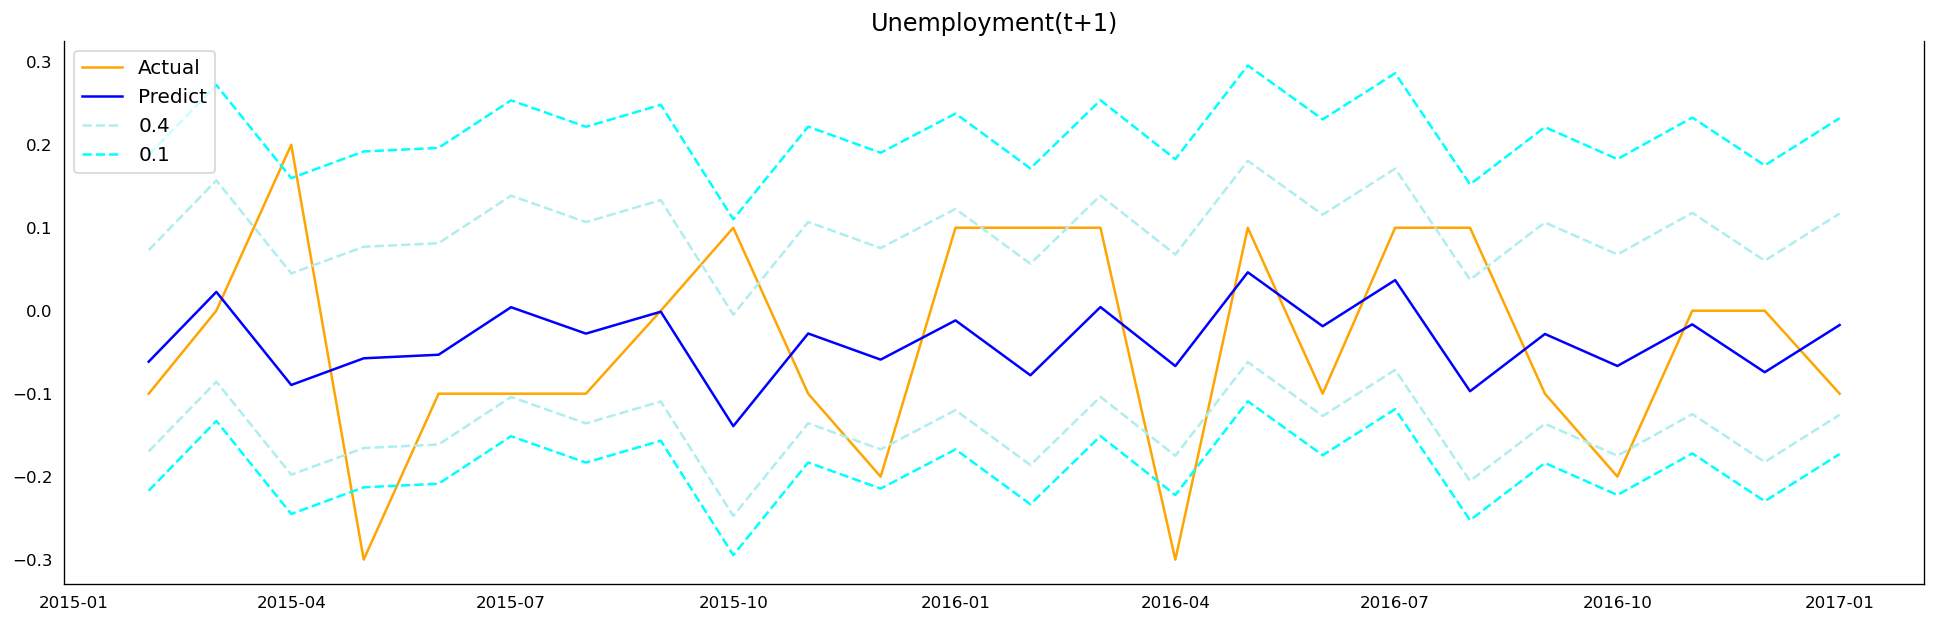

In [13]:
intervals = get_prediction_intervals(NN_results)
plot_results(result = NN_results, period = 'test', target_variable = variable, show_interval = True, intervals = intervals)